# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Load Data](#5.4_Load_Data)
  * [5.5 Feature Selection](#5.5_Feature_Selection)
  * [5.6 Dummy Model](#5.6_Dummy_Model)
  * [5.7 Decision Tree Classifier Model](#5.7_Decision_Tree_Classifier_Model)
  * [5.8 Basic Logistic Regression Model](#5.8_Basic_Logistic_Regression_Model)
  * [5.9 Logistic Regression Hyperparameter Tuning](#5.9_Logistic_Regression_Hyperparameter_Tuning)
  * [5.10 Random Forest](#5.10_Random_Forest)
  * [5.11 XGBoost](#5.11_XGBoost)
  * [5.12 Holdout Predictions](#5.12_Holdout_Predictions)
      * [5.12.1 Re-train Model](#5.12.1_Re-train_Model)
      * [5.12.2 Predict on Holdout](#5.12.2_Predict_on_Holdout)

## 5.2 Introduction<a id='5.2_Introduction'></a>

In this notebook, I am going to choose a model to predict whether a loan will default. Then I will test my chosen model on the hold-out set. 

## 5.3 Imports<a id='5.3_Imports'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import loadtxt
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, cross_validate
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.ensemble import RandomForestRegressor

## 5.4 Load Data<a id='5.4_Load_Data'></a>

In [3]:
XL_train = loadtxt('../data/X_train_L.csv', delimiter=',')
XL_test = loadtxt('../data/X_test_L.csv', delimiter=',')
yL_train = loadtxt('../data/y_train_L.csv', delimiter=',')
yL_test = loadtxt('../data/y_test_L.csv', delimiter=',')

In [4]:
XD_train = loadtxt('../data/X_train_D.csv', delimiter=',')
XD_test = loadtxt('../data/X_test_D.csv', delimiter=',')
yD_train = loadtxt('../data/y_train_D.csv', delimiter=',')
yD_test = loadtxt('../data/y_test_D.csv', delimiter=',')

In [ ]:
X_holdout = loadtxt('../holdout_data/X_holdout')
y_holdout = loadtxt('../holdout_data/y_holdout')

## 5.5 Feature Selection<a id='5.5_Feature_Selection'></a>

First I am going to get rid of features with little variance, using VarianceThreshold.

In [18]:
XD_train.shape

(571813, 198)

In [19]:
var = VarianceThreshold(threshold=0.05)

In [20]:
var.fit(XD_train)
XD_train = var.transform(XD_train)
XD_test = var.transform(XD_test)
XD_train.shape

(571813, 198)

In [21]:
XL_train.shape

(571813, 26)

In [22]:
var.fit(XL_train)
XL_train = var.transform(XL_train)
XL_test = var.transform(XL_test)
XL_train.shape

(571813, 24)

That VarianceThreshold transformation removed two columns from the label encoded training and test data.

## 5.6 Dummy Model<a id='5.6_Dummy_Model'></a>

In [5]:
dummy = DummyClassifier(strategy = 'most_frequent', random_state=121)
dummy.fit(XD_train, yD_train)

DummyClassifier(random_state=121, strategy='most_frequent')

In [6]:
dummy.score(XD_train, yD_train)

0.9554119965793013

.score is calculating the accuracy of the model. This score of 0.95 shows exactly why accuracy cannot be used for this dataset. The percentage of defaults in this data is approximately 5%. So, even with this dummy model which is predicting no loan defaults, it is accurate 94.7% of the time. 

For loan defaults, we care about minimizing both false positives and false negatives. Predicting false positives means that lenders will not loan money to borrowers who would have actually paid back the loan. This loses money for the banks and lenders. Predicting false negatives means that the borrow will be lent money that will not be paid back, and also loses the bank money.

The metrics that I will use to assess my model is the f1 score and the confusion matrix.

In [8]:
f1_score(yD_test, dummy.predict(XD_test))

0.0

Above, the f1 score is zero. This is exactly as expected and shows that this dummy model is useless for predicting loan defaults.

## 5.7 Decision Tree Classifier Model<a id='5.7_Decision_Tree_Classifier_Model'></a>

In [9]:
tree = DecisionTreeClassifier(criterion='gini')
tree.fit(XL_train, yL_train)

DecisionTreeClassifier()

In [10]:
y_pred = tree.predict(XL_test)

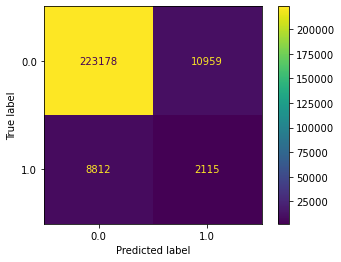

In [11]:
plot_confusion_matrix(tree, XL_test, yL_test)

In [12]:
print('The f1 score of the Decision Tree Classifier is: ', f1_score(yL_test, y_pred))

The f1 score of the Decision Tree Classifier is:  0.1762426565559768


This basic decision tree model is not great. Decision trees are also know for overfitting so they are not usually good for predicting unseen data. Let's see if there is a better model. 

## 5.8 Basic Logistic Regression Model<a id='5.8_Basic_Logistic_Regression_Model'></a>

In [13]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(XD_train, yD_train)

LogisticRegression(max_iter=1000)

In [17]:
y_pred_logreg = logreg.predict(XD_test)
print('The f1 score of the basic Logistic Regression model is: ', f1_score(yD_test, y_pred_logreg))

The f1 score of the basic Logistic Regression model is:  0.05134006265227985


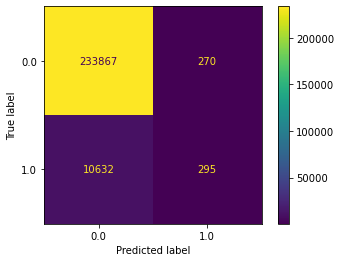

In [15]:
plot_confusion_matrix(logreg, XD_test, yD_test)

The f1 score for this basic Logistic Regression model is much worse than the basic decision tree. 

## 5.9 Logistic Regression Hyperparameter Tuning<a id='5.9_Logistic_Regression_Hyperparameter_Tuning'></a>

https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

In [27]:
logreg = LogisticRegression(max_iter=500)
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga']
penalty = ['l2', 'none']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=logreg, param_grid=grid, n_jobs=-1, cv=3, scoring='f1',error_score=0)
grid_result = grid_search.fit(XD_train, yD_train)

In [28]:
grid_result.best_params_

{'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

In [29]:
y_predict_grid = grid_result.predict(XD_test)

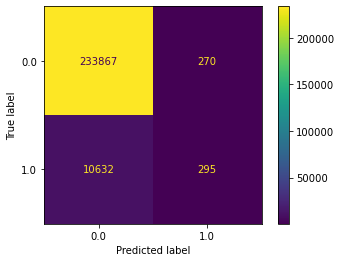

In [30]:
plot_confusion_matrix(grid_result, XD_test, yD_test)

In [31]:
print('The f1 score of the Logistic Regression model using hyperparameter tuning is: ', f1_score(yD_test, y_predict_grid))

The f1 score of the Logistic Regression model using hyperparameter tuning is:  0.05134006265227985


In [112]:
print('The recall score of the Logistic Regression model using hyperparameter tuning is: ', recall_score(yD_test, y_predict_grid))

The recall score of the Logistic Regression model using hyperparameter tuning is:  0.02699734602361124


## 5.10 Random Forest<a id='5.10_Random_Forest'></a>

The following random forest hyperparameter tuning was taken from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [32]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 35, 60, 85, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [33]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 15, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(XL_train, yL_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 93.8min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 270.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 270.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 35, 60, 85, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=42, verbose=2)

In [34]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [ ]:
print("Best: %f using %s" % (rf_random.best_score_, rf_random.best_params_))
means = rf_random.cv_results_['mean_test_score']
stds = rf_random.cv_results_['std_test_score']
params = rf_random.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [35]:
y_pred_forest = rf_random.best_estimator_.predict(XL_test)

In [93]:
thresholds = np.linspace(0,1,num=20)
f1_scores_rf = []
recall_scores_rf = []

for t in thresholds:
    f1_scores_rf.append(f1_score(yL_test, np.where(y_pred_forest > t, 1, 0)))
    recall_scores_rf.append(recall_score(yL_test, np.where(y_pred_xgb > t, 1, 0)))

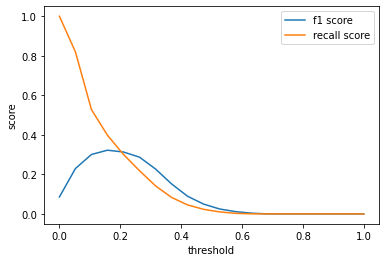

In [94]:
plt.plot(thresholds, f1_scores_rf, label='f1 score')
plt.plot(thresholds, recall_scores_rf, label='recall score')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('score')
plt.show()

In [104]:
y_pred_threshold = np.where(y_pred_forest > 0.5, 1, 0)

In [105]:
print('The best f1 score for the Random Forest model is: ', f1_score(yL_test, y_pred_threshold))

The best f1 score for the Random Forest model is:  0.03374178653880306


In [106]:
recall_score(yL_test, y_pred_threshold)

0.017388121167749612

In [107]:
confusion_matrix(yL_test, y_pred_threshold)

array([[233992,    145],
       [ 10737,    190]], dtype=int64)

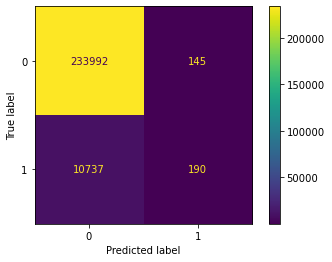

In [108]:
disp = ConfusionMatrixDisplay(confusion_matrix(yL_test, y_pred_threshold))
disp.plot()

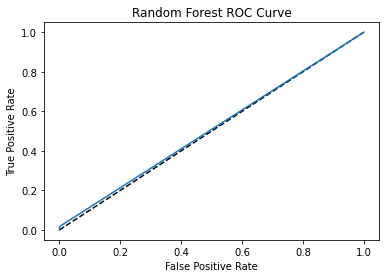

In [110]:
# Plot the ROC curve 
fpr, tpr, thresholds = roc_curve(yL_test, y_pred_threshold)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

In [111]:
roc_auc_score(yL_test, y_pred_xgb_thres)

0.528000597255723

## 5.11 XGBoost<a id='5.11_XGBoost'></a>

In [ ]:
! pip install xgboost

In [41]:
import xgboost as xgb

In [42]:
# Using RandomizedSearchCV from DataCamp XGBoost course
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'objective': ['reg:logistic', 'binary:logistic'],
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': [15, 25, 35],
    'max_depth': [3, 8, 12],
    'eta': [0.001, 0.01, 0.1]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

# Perform random search: grid_mse
randomized_xgb = GridSearchCV(gbm, param_grid=gbm_param_grid, cv=3, verbose=1, scoring="roc_auc")


# Fit randomized_mse to the data
randomized_xgb.fit(XL_train,yL_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_xgb.best_params_)
print("Best roc_auc found: ", randomized_xgb.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[21:57:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:57:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:57:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:57:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:00:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:00:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:00:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:00:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:03:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:03:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:03:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:03:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:06:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:06:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:06:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:06:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:10:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:14:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:14:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:14:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:14:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed: 22.5min finished


Best parameters found:  {'colsample_bytree': 0.7, 'eta': 0.1, 'max_depth': 8, 'n_estimators': 35, 'objective': 'reg:logistic'}
Best roc_auc found:  0.8516390052138069


In [44]:
y_pred_xgb = randomized_xgb.predict(XL_test)

C:\Users\McD\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [113]:
thresholds = np.linspace(0,1,num=20)
f1_scores = []
recall_scores = []
precision_scores = []

for t in thresholds:
    f1_scores.append(f1_score(yL_test, np.where(y_pred_xgb > t, 1, 0)))
    recall_scores.append(recall_score(yL_test, np.where(y_pred_xgb > t, 1, 0)))
    precision_scores.append(precision_score(yL_test, np.where(y_pred_xgb > t, 1, 0)))

C:\Users\McD\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


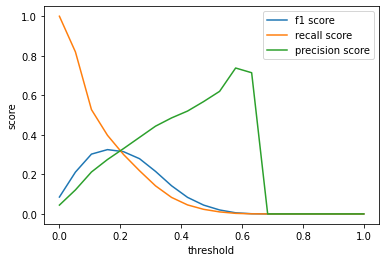

In [115]:
plt.plot(thresholds, f1_scores, label='f1 score')
plt.plot(thresholds, recall_scores, label='recall score')
plt.plot(thresholds, precision_scores, label = 'precision score')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('score')
plt.show()

In [84]:
y_pred_xgb_thres = np.where(y_pred_xgb > 0.4, 1, 0)

In [85]:
f1_score(yL_test, y_pred_xgb_thres)

0.10515954392584693

In [102]:
recall_score(yL_test, y_pred_xgb_thres)

0.05866202983435527

In [86]:
confusion_matrix(yL_test, y_pred_xgb_thres)

array([[233514,    623],
       [ 10286,    641]], dtype=int64)

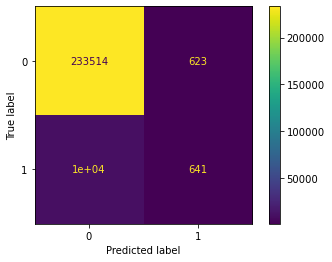

In [87]:
disp_xgbCM = ConfusionMatrixDisplay(confusion_matrix(yL_test, y_pred_xgb_thres))
disp_xgbCM.plot()

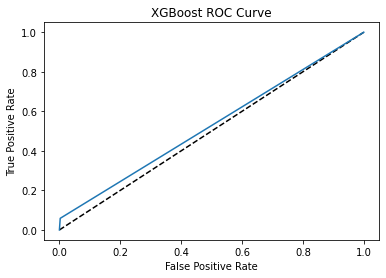

In [92]:
# Plot the ROC curve 
fpr, tpr, thresholds = roc_curve(yL_test, y_pred_xgb_thres)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.show()

In [91]:
roc_auc_score(yL_test, y_pred_xgb_thres)

0.528000597255723

## 5.12 Holdout Predictions<a id='5.12_Holdout_Predictions'></a>

### 5.12.1 Re-train Model<a id='5.12.1_Re-train_Model'></a>

### 5.12.2 Predict on Holdout<a id='5.12.2_Predict_on_Holdout'></a>